In [274]:
import pandas as pd
import numpy as np
from numpy import interp
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, ShuffleSplit
import warnings


In [275]:
warnings.filterwarnings('ignore')

In [276]:
# importing two datasets and concatting them into one dataset to test our models
df_lab = pd.read_csv('lab_results.csv')
df_field = pd.read_csv("field_results.csv",low_memory=False)

In [277]:
df = pd.concat([df_lab,df_field])


Importing first dataset to train models

In [278]:
water_one = pd.read_csv('new_water.csv')
del water_one["Unnamed: 0"]


In [279]:
water_one.head()


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [280]:
X = water_one.iloc[:, :-1]
y = water_one.iloc[:, -1]

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [282]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


K 0 train: [258 259 260 262 264 265 266 267 269 270] test [0 1 2 3 4 5 6 7 8 9]
auc= 0.6656250000000001
Training: 0.648854961832061
K 1 train: [0 1 2 3 4 5 6 7 8 9] test [258 259 260 262 264 265 266 267 269 270]
auc= 0.6708333333333333
Training: 0.6679389312977099
K 2 train: [0 1 2 3 4 5 6 7 8 9] test [511 512 523 524 528 529 530 531 532 533]
auc= 0.6612745098039217
Training: 0.6603053435114504
K 3 train: [0 1 2 3 4 5 6 7 8 9] test [772 775 780 781 783 786 787 788 793 794]
auc= 0.7166360294117647
Training: 0.7061068702290076
K 4 train: [0 1 2 3 4 5 6 7 8 9] test [1015 1017 1018 1019 1022 1023 1026 1031 1032 1036]
auc= 0.6723039215686274
Training: 0.6755725190839694
K 5 train: [0 1 2 3 4 5 6 7 8 9] test [1289 1290 1291 1293 1295 1298 1299 1300 1303 1309]
auc= 0.6329044117647058
Training: 0.683206106870229
K 6 train: [0 1 2 3 4 5 6 7 8 9] test [1545 1546 1550 1553 1557 1558 1563 1564 1567 1570]
auc= 0.7182904411764706
Training: 0.6984732824427481
K 7 train: [0 1 2 3 4 5 6 7 8 9] test [17

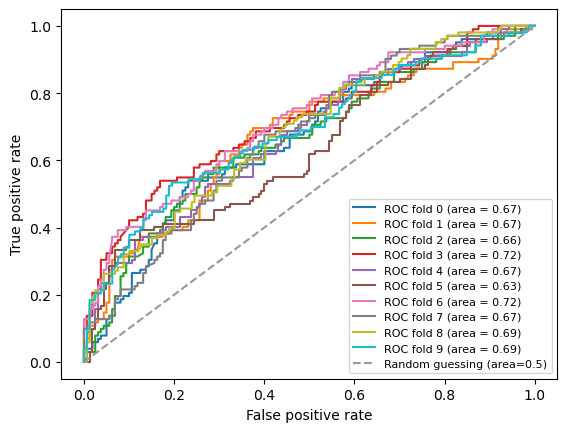

In [283]:
kfold = StratifiedKFold(n_splits=10).split(X_train_std,y_train)

training_acc = []
training_time = []
testing_acc = []
testing_time = []

for k,(train,test) in enumerate(kfold):
    print("K",k,"train:",train[:10],"test",test[:10])
    svm = SVC(kernel='rbf',random_state=1,gamma=0.12,C=2,probability=True) #probability=True for predict_proba
    
    train_start = time.perf_counter()
    svm.fit(X_train_std[train],y_train.iloc[train].values)
    train_end = time.perf_counter() - train_start
    
    # for roc and auc
    probas = svm.predict_proba(X_train_std[test])
    fpr,tpr,thresholds = roc_curve(y_train.iloc[test],
                                   probas[:,1],
                                   pos_label=1)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,label="ROC fold %d (area = %0.2f)" % (k,roc_auc))
    print("auc=",roc_auc)
    # end of roc and auc
    
    y_pred = svm.predict(X_train_std[test]) # changing x_test_std to x_train_std ### typo in lec10 slide 9
    score = svm.score(X_train_std[test],y_train.iloc[test])
    print("Training:",score)
    training_acc.append(score)
    training_time.append(train_end)
    
print("~~"*15)
print("Training Time: %.3f" % np.sum(training_time))
print("Training Accuracy: %.3f" % np.mean(training_acc))

plt.plot([0,1],[0,1],linestyle='--',color=(0.6,0.6,0.6),label='Random guessing (area=0.5)')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right',fontsize='8')




In [284]:
# get predictions for test data using the first dataset 
test_start = time.perf_counter()
y_pred_test = svm.predict(X_test_std)
test_end = time.perf_counter() - test_start
# get prediction score for test data
score_test = svm.score(X_test_std,y_test)

print('Testing Time: %.3f' % test_end)
print("Testing Accuracy: %.3f" % score_test)

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred_test))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred_test))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred_test))


# results for first dataset


Testing Time: 0.120
Testing Accuracy: 0.694
Precision: 0.701
Recall: 0.375
F1: 0.489


Beginning of code for second dataset--completed by Karlee


In [285]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5532362 entries, 0 to 999998
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   station_id          int64  
 1   station_name        object 
 2   full_station_name   object 
 3   station_number      object 
 4   station_type        object 
 5   latitude            float64
 6   longitude           float64
 7   status              object 
 8   county_name         object 
 9   sample_code         object 
 10  sample_date         object 
 11  sample_depth        float64
 12  sample_depth_units  object 
 13  parameter           object 
 14  result              float64
 15  reporting_limit     float64
 16  units               object 
 17  method_name         object 
 18  anl_data_type       object 
 19  fdr_text_result     object 
 20  fdr_date_result     object 
 21  fdr_footnote        object 
dtypes: float64(5), int64(1), object(16)
memory usage: 970.8+ MB


In [286]:
df.describe()


,station_id,latitude,longitude,sample_depth,result,reporting_limit
count,5.532362e+06,5.407287e+06,5.407287e+06,2.301853e+06,5.391520e+06,5.380309e+06
mean,1.604094e+04,3.706993e+01,1.195733e+02,5.944015e+00,3.165443e+02,6.825690e-01
std,1.726809e+04,2.382138e+00,1.389091e+01,3.636480e+01,4.227465e+03,1.043378e+01
min,1.000000e+00,3.254170e+01,-1.214820e+02,-3.500000e-01,-2.161000e+02,0.000000e+00
25%,1.785000e+03,3.449100e+01,1.186101e+02,3.000000e-01,3.000000e-01,1.000000e-01
50%,6.056000e+03,3.767580e+01,1.212093e+02,1.000000e+00,8.500000e+00,2.000000e-01
75%,3.030100e+04,3.880640e+01,1.217494e+02,1.000000e+00,7.400000e+01,1.000000e+00
max,4.792900e+04,4.203440e+01,1.244006e+02,1.210000e+03,5.000000e+06,1.000000e+04


In [287]:
df.describe(include=["object", "bool"])


,station_name,full_station_name,station_number,station_type,status,county_name,sample_code,sample_date,sample_depth_units,parameter,units,method_name,anl_data_type,fdr_text_result,fdr_date_result,fdr_footnote
count,5532362,5532362,5532362,5532362,5532362,5532362,5532362,5532362,5532362,5532362,5532362,5532362,109619,100562,3350,98243
unique,44248,46485,44199,3,2,58,367479,397384,3,489,52,344,5,2016,118,7831
top,H.O. Banks Headworks,Delta P.P. Headworks at H.O. Banks PP,KA000331,Surface Water,Review Status Unknown,Los Angeles,SA0911B0508,08/14/1951 00:00,Feet,pH,mg/L,EPA 170.1 (Field),Memo,*See Units Note,1899-12-30,",Whitney,LMT-8A,n/p"
freq,63754,63754,63754,3510746,5507157,554533,222,3166,4079533,364511,2434868,225741,92433,76984,1669,4756


Extract column values by using dataframe.loc[] property.

To get first element by using .iloc[] method.

In [289]:
df.loc[df['sample_date']==df['sample_date'].unique()[0],'result'].iloc[0]


3480.0

In [290]:
j = 0
for i in df['sample_date'].unique():
    print(i)
    print(df.loc[df['sample_date']==i,('parameter','result','units')])
    if j == 3:
        break
    j = j + 1    
    #break
    

05/03/1967 09:00
                                      parameter  result              units
0                                   Conductance  3480.0              uS/cm
1                               Dissolved Boron     7.7               mg/L
2                             Dissolved Calcium    68.0               mg/L
3                            Dissolved Chloride   758.0               mg/L
4                           Dissolved Magnesium    59.0               mg/L
5                              Dissolved Sodium   510.0               mg/L
6                              Total Alkalinity   270.0      mg/L as CaCO3
7                                Total Hardness   412.0      mg/L as CaCO3
8                                            pH     8.0           pH Units
1915369                             Conductance    70.0              uS/cm
1915370  Dissolved Acid Hydrolyzable Phosphorus     0.1          mg/L as P
1915371                         Dissolved Boron     0.0               mg/L
1915372 

In [291]:
new_col = pd.to_datetime(df.sample_date).dt.strftime('%Y-%m-%d %H:%M:%S')


In [292]:
df['formatted_datetime'] = new_col


In [293]:
df_piv = pd.pivot_table(df,index='formatted_datetime',columns='parameter',values='result')


In [294]:
df_piv.describe()


parameter,(Aminomethyl)phosphonic acid,(Bottom) DissolvedOxygen,(Bottom) SpecificConductance,(Bottom) WaterTemperature,(Bottom)Chlorophyll Fluorescence,(Bottom)Turbidity,(Bottom)Water Depth at Station,(Bottom)pH,1% Light Depth,"1,1,1,2-Tetrachloroethane",...,"p,p'-DDE","p,p'-DDT",p-Xylene,pH,pH (w/time),"s,s,s-Tributyl Phosphorotrithioate (DEF)",sec-Butylbenzene,tert-Butylbenzene,"trans-1,2-Dichloroethene","trans-1,3-Dichloropropene"
count,231.0,1584.000000,1639.000000,1582.000000,1578.000000,1641.000000,15.000000,1641.000000,4025.000000,2783.0,...,1218.0,1219.0,606.000000,197315.000000,4.000000,1529.000000,2789.000000,2783.000000,2897.0,2783.0
mean,0.0,31.696768,11110.127175,16.596833,2.510323,25.291968,9.293333,7.670780,1.411549,0.0,...,0.0,0.0,0.001650,7.876126,8.755000,0.003355,0.001673,0.000350,0.0,0.0
std,0.0,20.572254,14357.600950,4.666070,1.898372,34.062882,2.178291,0.252516,0.587837,0.0,...,0.0,0.0,0.040622,18.752180,0.531068,0.054454,0.031673,0.013071,0.0,0.0
min,0.0,6.140000,74.670000,8.190000,-0.270000,0.000000,6.400000,6.620000,0.160000,0.0,...,0.0,0.0,0.000000,-0.180000,8.100000,0.000000,0.000000,0.000000,0.0,0.0
25%,0.0,8.947500,230.000000,12.380000,1.380000,6.100000,7.150000,7.510000,1.000000,0.0,...,0.0,0.0,0.000000,7.500000,8.482500,0.000000,0.000000,0.000000,0.0,0.0
50%,0.0,45.905000,1215.000000,16.645000,1.972500,15.100000,9.500000,7.690000,1.310000,0.0,...,0.0,0.0,0.000000,7.800000,8.785000,0.000000,0.000000,0.000000,0.0,0.0
75%,0.0,50.550000,20252.500000,20.540000,3.000000,30.300000,10.350000,7.840000,1.700000,0.0,...,0.0,0.0,0.000000,8.050000,9.057500,0.000000,0.000000,0.000000,0.0,0.0
max,0.0,70.610000,46258.000000,29.900000,22.830000,412.200000,13.400000,9.030000,5.610000,0.0,...,0.0,0.0,1.000000,7397.000000,9.350000,1.470000,0.800000,0.500000,0.0,0.0


In [295]:
parameters = ['pH','Total Hardness','Total Dissolved Solids','Dissolved Chloride','Dissolved Sulfate','Conductance','Total Organic Carbon','Trihalomethane Formation Potential (THMFP)','Turbidity']

In [296]:
df2 = df_piv[parameters]

In [297]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 235387 entries, 1903-03-23 00:00:00 to 2023-02-15 13:45:00
Data columns (total 9 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   pH                                          197315 non-null  float64
 1   Total Hardness                              100261 non-null  float64
 2   Total Dissolved Solids                      117363 non-null  float64
 3   Dissolved Chloride                          169162 non-null  float64
 4   Dissolved Sulfate                           116795 non-null  float64
 5   Conductance                                 157999 non-null  float64
 6   Total Organic Carbon                        21508 non-null   float64
 7   Trihalomethane Formation Potential (THMFP)  127 non-null     float64
 8   Turbidity                                   114666 non-null  float64
dtypes: float64(9)
memory usage: 18.0+ MB


In [298]:
j = 0
units = {}
for i in parameters:
    x = df.loc[df['parameter']==i,('parameter','units')].iloc[0]
    units.setdefault(x[0],x[1])    

In [299]:
for k,v in units.items():
    print(k,":",v)   

pH : pH Units
Total Hardness : mg/L as CaCO3
Total Dissolved Solids : mg/L at 180 °C
Dissolved Chloride : mg/L
Dissolved Sulfate : mg/L
Conductance : uS/cm
Total Organic Carbon : mg/L as C
Trihalomethane Formation Potential (THMFP) : ug/L
Turbidity : N.T.U.


In [300]:
drop_df = df2.dropna(axis=0,how='all')

In [301]:
# visualizing to ensure no NA values
drop_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227695 entries, 1903-03-23 00:00:00 to 2023-02-15 13:45:00
Data columns (total 9 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   pH                                          197315 non-null  float64
 1   Total Hardness                              100261 non-null  float64
 2   Total Dissolved Solids                      117363 non-null  float64
 3   Dissolved Chloride                          169162 non-null  float64
 4   Dissolved Sulfate                           116795 non-null  float64
 5   Conductance                                 157999 non-null  float64
 6   Total Organic Carbon                        21508 non-null   float64
 7   Trihalomethane Formation Potential (THMFP)  127 non-null     float64
 8   Turbidity                                   114666 non-null  float64
dtypes: float64(9)
memory usage: 17.4+ MB


In [302]:
drop_df.median(axis=0)

parameter
pH                                              7.8
Total Hardness                                144.0
Total Dissolved Solids                        289.0
Dissolved Chloride                             34.0
Dissolved Sulfate                              41.0
Conductance                                   475.0
Total Organic Carbon                            3.2
Trihalomethane Formation Potential (THMFP)    240.0
Turbidity                                       8.0
dtype: float64

In [303]:
df_filled = drop_df.fillna(drop_df.median())

In [304]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227695 entries, 1903-03-23 00:00:00 to 2023-02-15 13:45:00
Data columns (total 9 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   pH                                          227695 non-null  float64
 1   Total Hardness                              227695 non-null  float64
 2   Total Dissolved Solids                      227695 non-null  float64
 3   Dissolved Chloride                          227695 non-null  float64
 4   Dissolved Sulfate                           227695 non-null  float64
 5   Conductance                                 227695 non-null  float64
 6   Total Organic Carbon                        227695 non-null  float64
 7   Trihalomethane Formation Potential (THMFP)  227695 non-null  float64
 8   Turbidity                                   227695 non-null  float64
dtypes: float64(9)
memory usage: 17.4+ MB


In [305]:
df2.describe() # bunch of NaN's


parameter,pH,Total Hardness,Total Dissolved Solids,Dissolved Chloride,Dissolved Sulfate,Conductance,Total Organic Carbon,Trihalomethane Formation Potential (THMFP),Turbidity
count,197315.000000,100261.000000,117363.000000,169162.000000,116795.000000,157999.000000,21508.000000,127.000000,114666.000000
mean,7.876126,309.701538,1240.485814,361.896261,298.223391,1663.533912,6.089646,338.215223,24.686145
std,18.752180,744.674041,4186.592533,1786.583991,1199.945048,5274.377680,22.202242,345.853915,148.691170
min,-0.180000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,-3.200000
25%,7.500000,70.000000,124.000000,8.000000,11.000000,227.000000,2.100000,180.000000,3.000000
50%,7.800000,144.000000,289.000000,34.000000,41.000000,475.000000,3.200000,240.000000,8.000000
75%,8.050000,297.000000,672.000000,102.000000,164.000000,1012.000000,4.900000,375.000000,20.000000
max,7397.000000,50604.000000,245534.000000,79000.000000,49300.000000,408000.000000,600.000000,3400.000000,9920.000000


In [306]:
def add_class_label(row):
    class_label = 1
    if row['pH'] < 6.5 and row['pH'] > 8.5:
        class_label = 0
    if row['Total Dissolved Solids'] > 500.0:
        class_label = 0
    if row['Dissolved Chloride'] > 26.0:
        class_label = 0
    if row['Dissolved Sulfate'] > 250.0:
        class_label = 0
    if row['Conductance'] > 400.0:
        class_label = 0
    if row['Total Organic Carbon'] > 2.0: # 2 gives 341 1's but 4.0 gives 44603 1's
        class_label = 0
    if row['Trihalomethane Formation Potential (THMFP)'] > 320:
        class_label = 0
    if row['Turbidity'] > 40.0:
        class_label = 0
    return class_label


In [307]:
df_filled['potability'] = df_filled.apply(lambda row: add_class_label(row), axis=1)
# adding in class labels to dataset 


In [308]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227695 entries, 1903-03-23 00:00:00 to 2023-02-15 13:45:00
Data columns (total 10 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   pH                                          227695 non-null  float64
 1   Total Hardness                              227695 non-null  float64
 2   Total Dissolved Solids                      227695 non-null  float64
 3   Dissolved Chloride                          227695 non-null  float64
 4   Dissolved Sulfate                           227695 non-null  float64
 5   Conductance                                 227695 non-null  float64
 6   Total Organic Carbon                        227695 non-null  float64
 7   Trihalomethane Formation Potential (THMFP)  227695 non-null  float64
 8   Turbidity                                   227695 non-null  float64
 9   potability                                  

In [309]:
df_filled['potability'].value_counts()


0    227354
1       341
Name: potability, dtype: int64

Kernel SVM model for second water dataset completed by Karlee:


In [310]:
# parameter names for reference 

# parameters = ['pH','Total Hardness','Total Dissolved Solids','Dissolved Chloride','Dissolved Sulfate',
# 'Conductance','Total Organic Carbon','Trihalomethane Formation Potential (THMFP)','Turbidity']

x_second = df_filled.iloc[:, :-1]
y_second = df_filled.iloc[:, -1]

In [311]:
# renaming column names to ensure they match with the first dataset 

x_second = x_second.rename(columns={'pH':'ph', 'Total Hardness':'Hardness', 'Total Dissolved Solids':'Solids', 'Dissolved Chloride':'Chloramines', 
                  'Dissolved Sulfate':'Sulfate', 'Conductance':'Conductivity', 'Total Organic Carbon':'Organic_carbon',
                  'Trihalomethane Formation Potential (THMFP)':'Trihalomethanes','Turbidity':'Turbidity'})

In [312]:
x_second.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity'],
      dtype='object', name='parameter')

In [313]:
# scale second dataset

x_second_std = sc.transform(x_second)

In [314]:
# get predictions for test data
second_test_start = time.perf_counter()
y_pred_second = svm.predict(x_second_std)
second_test_end = time.perf_counter() - test_start
# get prediction score for standardized test data
second_score_test = svm.score(x_second_std,y_second)

print('Testing Time: %.3f' % second_test_end)
print("Testing Accuracy: %.3f" % second_score_test)

# print('Second Precision: %.3f' % precision_score(y_true=y_second, y_pred=y_pred_second))
# print('Second Recall: %.3f' % recall_score(y_true=y_second, y_pred=y_pred_second))
# print('Second F1: %.3f' % f1_score(y_true=y_second, y_pred=y_pred_second))

precision, recall, f1_score, _ = precision_recall_fscore_support(y_second, y_predict, average='macro')
print("Macro-averaged Precision:", precision)
print("Macro-averaged Recall:", recall)
print("Macro-averaged F1 Score:", f1_score)



Testing Time: 263.827
Testing Accuracy: 0.001
Macro-averaged Precision: 0.4992511024825623
Macro-averaged Recall: 0.49994062123384675
Macro-averaged F1 Score: 0.49959562394785306


In [317]:
print('AUC Score: %.3f' % roc_auc_score(y_true=y_second,y_score=y_pred_second))


AUC Score: 0.500


AUC score is as good as random guessing


Decision Tree and Random Forest Classifiers completed by Cameron:


Decision Tree Model Scores:
Precision:  1.0
Recall:  1.0
F1:  1.0
AUC:  1.0
Train Time:  0.041809797286987305
Decision Tree Accuracy:  1.0

Random Forest Model Scores:
Precision:  0.002
Recall:  0.988
F1:  0.84
AUC:  0.862
Train Time:  0.40050220489501953
Random Forest Accuracy:  0.068


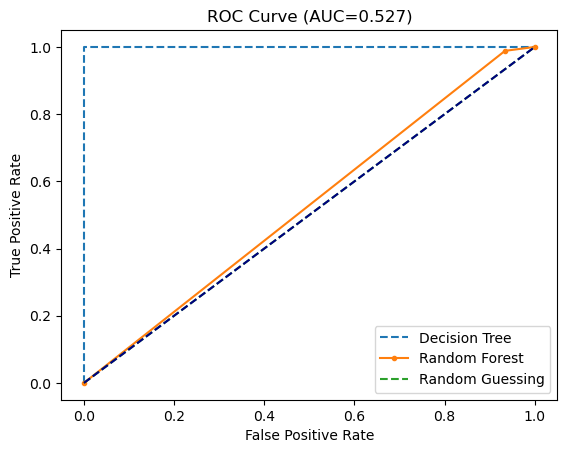

In [318]:
# Create a decision tree classifier and fit it to the training set
start_time = time.time()
dt_water = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
dt_water.fit(X_train, y_train)
train_time_dt = time.time() - start_time

y_second_pred_dt = dt.predict(x_second)
precision_dt = round(precision_score(y_second, y_second_pred_dt), 3)
recall_dt = round(recall_score(y_second, y_second_pred_dt), 3)

# WHEN UNCOMMENTED, IT GIVES THE ERROR
# f1_dt = round(f1_score(y_second, y_second_pred_dt), 3)

auc_dt = round(roc_auc_score(y_second, y_second_pred_dt), 3)
acc_dt = round(accuracy_score(y_second, y_second_pred_dt), 3)

# precision, recall, F1, and AUC scores 
print("Decision Tree Model Scores:")
print("Precision: ", precision_dt)
print("Recall: ", recall_dt)
print("F1: ", f1_dt)
print("AUC: ", auc_dt)
print("Train Time: ", train_time_dt)
print("Decision Tree Accuracy: ", acc_dt)


# random forest classifier 
start_time = time.time()
rf = RandomForestClassifier(max_depth=4, random_state=1)
rf.fit(X_train, y_train)
train_time_rf = time.time() - start_time

y_second_pred_rf = rf.predict(x_second)

precision_rf = round(precision_score(y_second, y_second_pred_rf), 3)

recall_rf = round(recall_score(y_second, y_second_pred_rf), 3)

# WHEN UNCOMMENTED, IT GIVES THE ERROR
# f1_rf = round(f1_score(y_second, y_second_pred_rf), 3)

# accuracy score 
acc_rf = round(accuracy_score(y_second, y_second_pred_rf), 3)

# auc score
roc_auc_rf = round(roc_auc_score(y_second, y_second_pred_rf), 3)

# precision, recall, F1, and AUC scores
print("\nRandom Forest Model Scores:")
print("Precision: ", precision_rf)
print("Recall: ", recall_rf)
print("F1: ", f1_rf)
print("AUC: ", auc_rf)
print("Train Time: ", train_time_rf)
# print("Train Accuracy: ", acc_train_rf)
print("Random Forest Accuracy: ", acc_rf)


# # ROC CURVE

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_second, y_second_pred_dt)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_second, y_second_pred_rf)

# random guessing baseline
random_probs = [0 for _ in range(len(y_second))]
fpr_random, tpr_random, _ = roc_curve(y_second, random_probs)
 
plt.plot(fpr_dt, tpr_dt, linestyle='--', label='Decision Tree')
plt.plot(fpr_rf, tpr_rf, marker='.', label='Random Forest')
plt.plot(fpr_random, tpr_random, linestyle='--', label='Random Guessing')

# Plot the ROC curve for random guessing (baseline)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Add axis labels and a title to the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC={})'.format(roc_auc_rf))

plt.legend()
plt.show()

Logistic Regression using the second water potability dataset completed by Cameron

In [319]:
LogReg = LogisticRegression(C = 1.0, solver='liblinear', random_state=42)
# CHANGE TO FIT/TRAIN USING FIRST DATASET (use X_train_std, y_train to fit the data and x_second_std to test/predict)
LogReg.fit(X_train_std, y_train)
train_time = time.time() - start_time
# Make predictions on the scaled testing data
# y_pred = LogReg.predict(x_second_std)
# train_time = time.time() - start_time

# predict = LogReg.predict(x_second_std)
# print('Testing Accuracy: %.3f' % accuracy_score(y_second, predict))
# Log Reg accuracy of training dataset

# Using second dataset to make predictions
y_predict = LogReg.predict(x_second_std)
water_acc = accuracy_score(y_second, y_predict)
print("Accuracy of second dataset using log regression: %.3f" % water_acc)
test_time = time.time() - start_time

precision, recall, f1_score, _ = precision_recall_fscore_support(y_second, y_predict, average='macro')

# Print the macro-averaged precision, recall, and F1 score
print("Macro-averaged Precision:", precision)
print("Macro-averaged Recall:", recall)
print("Macro-averaged F1 Score:", f1_score)

# changed the solver from 'lbfgs' to 'liblinear' due to model not converging

Accuracy of second dataset using log regression: 0.017
Macro-averaged Precision: 0.5003354436473402
Macro-averaged Recall: 0.503474357569733
Macro-averaged F1 Score: 0.01700794652487134


KNN Classifier for second water dataset completed by Ahsan

In [320]:
train_time = time.time()
knn = KNeighborsClassifier()
knn.fit(X_train_std, y_train)
param_grid = {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_std, y_train)


# Report the training and testing accuracy, fitting time, and best hyperparameters
# print("Training accuracy:", accuracy_score(y_second, grid_search.predict(X_train)))
print("accuracy on second dataset using KNN:", accuracy_score(y_second, grid_search.predict(x_second_std)))
print("Best hyperparameters:", grid_search.best_params_)

# Calculate precision, recall, and F1 score
y_pred = grid_search.predict(x_second_std)
print(classification_report(y_second, y_pred))
testing_time = time.time()
print("training time for training data:", time.time() - train_time)
print("Testing time :", time.time() - testing_time)


# Plot the learning curve
# cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
# train_sizes, train_scores, test_scores = learning_curve(
#     estimator=knn, X=x_second_std, y=y_second, cv=cv, scoring='accuracy',
#     train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True)
# train_scores_mean = np.mean(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)

# plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
# plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Testing Score')
# plt.xlabel('Training Examples')
# plt.ylabel('Score')
# plt.title('Learning Curve')
# plt.legend(loc='best')
# plt.show()

# cannot run learning curve, too time consuming

accuracy on second dataset using KNN: 0.2218537956476866
Best hyperparameters: {'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       1.00      0.22      0.36    227354
           1       0.00      0.31      0.00       341

    accuracy                           0.22    227695
   macro avg       0.50      0.26      0.18    227695
weighted avg       0.99      0.22      0.36    227695

training time for training data: 32.837409019470215
Testing time : 8.392333984375e-05


Linear SVM model for second dataset completed by Jamira 

In [321]:
train_time = time.time()
svm_linear = SVC(kernel='linear', C=1.0, random_state=1)
svm_linear.fit(X_train_std, y_train)
test_time = time.time()
y_predict = svm_linear.predict(x_second_std)
print('Accuracy in second dataset: %.2f' % accuracy_score(y_second, y_predict))
class_pred = svm_linear.predict(x_second_std[:10, :])
print('These are the class predictions for the first 10 examples in the testing data \n', class_pred)

# PRECISION/RECALL/F1 SCORES
precision, recall, f1_score, _ = precision_recall_fscore_support(y_second, y_predict, average='macro')
print("Macro-averaged Precision:", precision)
print("Macro-averaged Recall:", recall)
print("Macro-averaged F1 Score:", f1_score)
print('training time:', time.time() - train_time)
print('Testing time:', time.time() - test_time)

# code for learning curve(cannot run, takes too long)

# cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
# train_sizes, train_scores, test_scores = learning_curve(
#     estimator=svm_linear, X=x_second_std, y=y_second, cv=cv, scoring='accuracy',
#     train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True)
# train_scores_mean = np.mean(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)

# plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
# plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Testing Score')
# plt.xlabel('Training Examples')
# plt.ylabel('Score')
# plt.title('Learning Curve')
# plt.legend(loc='best')
# plt.show()
        


Accuracy in second dataset: 1.00
These are the class predictions for the first 10 examples in the testing data 
 [0 0 0 0 0 0 0 0 0 0]
Macro-averaged Precision: 0.4992511024825623
Macro-averaged Recall: 0.49994062123384675
Macro-averaged F1 Score: 0.49959562394785306
training time: 13.90514612197876
Testing time: 13.54940915107727


In [272]:
# cv = list(StratifiedKFold(n_splits=10).split(x_second_std, y_second))
# fig = plt.figure(figsize=(7, 5))
# mean_tpr = 0.0
# mean_fpr = np.linspace(0, 1, 100)
# all_tpr = []
# for i, (train, test) in enumerate(cv):
#     probas = svm_linear.fit(x_second_std[train],
#                          y_second.iloc[train]).predict_proba(x_second_std[test], probability = True)

#     fpr,tpr, thresholds = roc_curve(y_second.iloc[test], probas[:, 1], pos_label=1)
#     mean_tpr += interp(mean_fpr, fpr, tpr)
#     mean_tpr[0] = 0.0
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

    
# plt.plot([0, 1], [0, 1], linestyle='--',
#         color=(0.6, 0.6, 0.6), label='Random guessing (area=0.5)')

# mean_tpr /= len(cv)
# mean_tpr[-1] = 1.0
# mean_auc = auc(mean_fpr, mean_tpr)
# plt.plot(mean_fpr, mean_tpr, 'k--',
#         label=f'MeanROC (area = {mean_auc:.2f})', lw=2)

# plt.plot([0, 0, 1], 
#         [0, 1, 1],
#         linestyle=':',
#         color='black',
#         label='Perfect performance (area = 1.0)')

# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.legend(loc='lower right')
# plt.show()

# does not run (added probability = True, did not correct the error for predict_proba function)